# DCGAN to generate MNIST images
We will follow the Machine Learning Project Checklist from the book "Hands-On Machine Learning with Scikit-Learn and TensorFLow".  

It contains eight steps (we interpret these as advice, not rules):
1. Frame the problem and look at the big picture  
2. Get the data  
3. Explore the data to gain insights  
4. Prepare the data to better expose the underlying data patterns to Machine Learning algorithms  
5. Explore many different models and short-list the best ones  
6. Fine-tune your models and combine them into a great solution  
7. Present your solution  
8. Launch, monitor and maintain your system (not applicable to us)



In [82]:
# Imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# to make this notebook's output stable across runs (from lab2)
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 1.11.0


## 1. Frame the Problem and Look at the Big Picture

**How is performance measured:** The DCGAN's performance is measured by us (and our teacher) by interpreting the overall quality of the resulting image. Basically, the performance is good if we can look at a generated MNIST image and think that a human have written it. 

## 2. Get the Data
Fetch the data

In [84]:
mnist = keras.datasets.mnist
(train_imgs, train_labels), (test_imgs, test_labels) = mnist.load_data()

Preprocess the data

Verify the data's shape

In [81]:
print(f"Train images shape: {train_imgs.shape}")
print(f"Train images data type: {train_imgs.dtype}")

Train images shape: (60000, 28, 28)
Train images data type: uint8


## 3. Explore the data to gain insights  
Below, we can see five images from each MNIST class

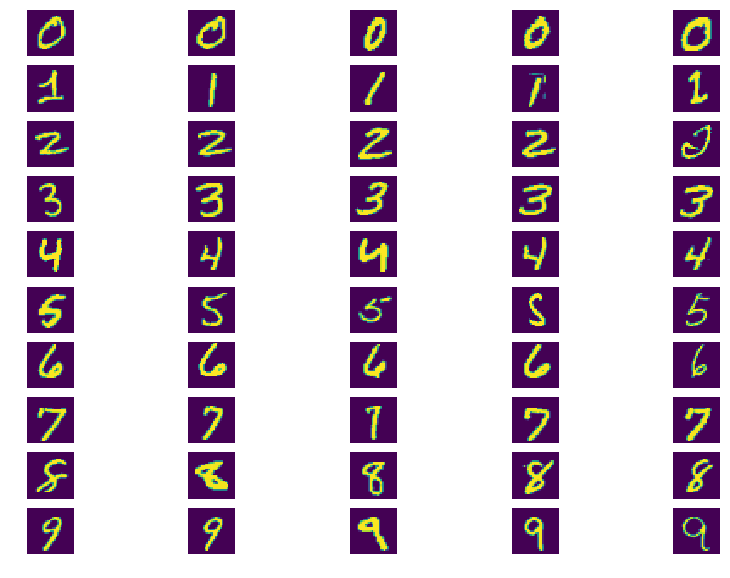

In [80]:
fig = plt.figure()
plt.rcParams["figure.figsize"] = (14,10)

currentClass = 0 # Decides which MNIST class to print

for i in range(1, 51):
    imageIdx = np.nonzero(train_labels == currentClass)[0] # This finds the indices of specific classes
    imgToPrint = imageIdx[i-1]
    fig.add_subplot(10,5,i).imshow(train_imgs[imgToPrint,:,:])
    plt.axis("off")
    
    if i % 5 == 0:
        currentClass += 1 # Go to next class

Examine the distribution of classes in the MNIST dataset.

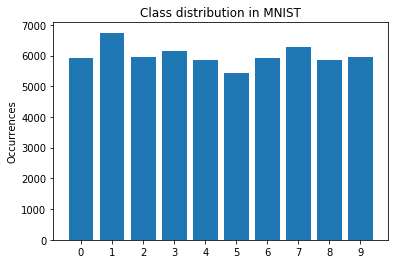

In [110]:
# Gather the count for each class, 0-9
classCount = []
for i in range(10):
    classCount.append(len(np.nonzero(train_labels == i)[0]))

# Display a bar chart with the counts
plt.bar(np.arange(10), classCount)
plt.xticks(np.arange(10), [0,1,2,3,4,5,6,7,8,9])
plt.ylabel("Occurrences")
plt.title("Class distribution in MNIST")

plt.show()

## 4. Prepare the data to better expose the underlying data patterns to Machine Learning algorithms

## 5. Explore many different models and short-list the best ones

## 6. Fine-tune your models and combine them into a great solution

## 7. Present your solution 